<br><br><br><br>
<h1>01. Exploring Marginal Distributions of stock data returns</h1>

<p>Applying heteroskedastic time series models to asset data and retrieving the marginal distribution.</p>

<br><br><br><br>
<h2>0. Document setup</h2>

In [51]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf

# Add project root so we can import from src/
project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

<br><br><br><br>
<h2>1. Data preparation</h2>

In [2]:
from src.data_handlers.yfinance_data_loader import load_prices

prices_appl = load_prices("AAPL", "2015-01-01", "2024-01-01")

prices_ge = load_prices("GE", "2015-01-01", "2024-01-01")


/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, index_col=0, parse_dates=True)
/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)
/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:55: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False, group_by="column")


[load_prices] Cache file is invalid, redownloading: AAPL_2015-01-01_2024-01-01.csv


/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, index_col=0, parse_dates=True)
/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)
/Users/isakdrougge/GitHub-Repos/applications-copula-methods-in-finance/src/data_handlers/yfinance_data_loader.py:55: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False, group_by="column")


[load_prices] Cache file is invalid, redownloading: GE_2015-01-01_2024-01-01.csv


In [3]:
prices_ge.head()

,Close,High,Low,Open,Volume
2015-01-02,102.697220,104.336443,101.918592,103.844673,8538620
2015-01-05,100.812119,102.492319,100.484277,102.492319,8770735
2015-01-06,98.640160,100.689185,98.066436,100.238399,13304295
2015-01-07,98.681129,99.951527,98.271320,99.213876,9106535
2015-01-08,99.869560,99.910537,98.886028,99.664656,9019294


In [4]:

prices_appl.head()

,Close,High,Low,Open,Volume
2015-01-02,24.237551,24.705320,23.798600,24.694235,212818400
2015-01-05,23.554745,24.086805,23.368524,24.006996,257142000
2015-01-06,23.556957,23.816336,23.195599,23.619031,263188400
2015-01-07,23.887280,23.987040,23.654503,23.765348,160423600
2015-01-08,24.805080,24.862721,24.097883,24.215381,237458000


<br><br><br><br>
<h3>Price plots</h3>

<Axes: title={'center': 'GE price'}>

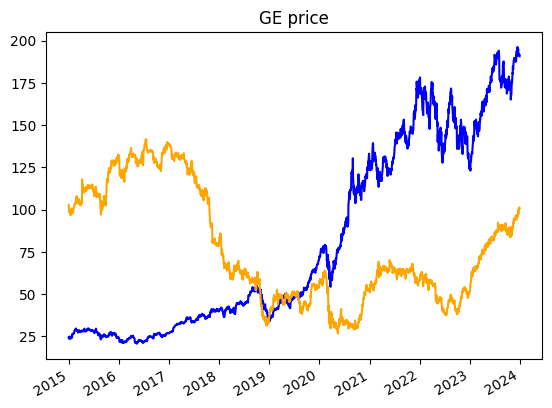

In [29]:
prices_appl["Close"].plot(title="AAPL price", color="b")
prices_ge["Close"].plot(title="GE price", color="orange")

<br><br><br><br>
<h3>Extracting log returns</h3>

In [7]:
returns_aapl = np.log(prices_appl["Close"]).diff().dropna()
returns_ge   = np.log(prices_ge["Close"]).diff().dropna()

<Axes: title={'center': 'AAPL log returns'}>

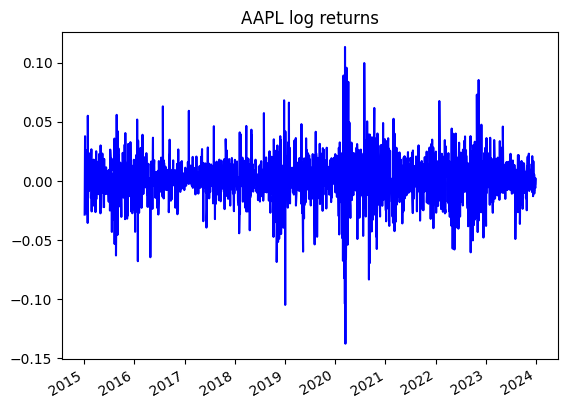

In [30]:
returns_aapl.plot(title="AAPL log returns", color="b")


<Axes: title={'center': 'GE log returns'}>

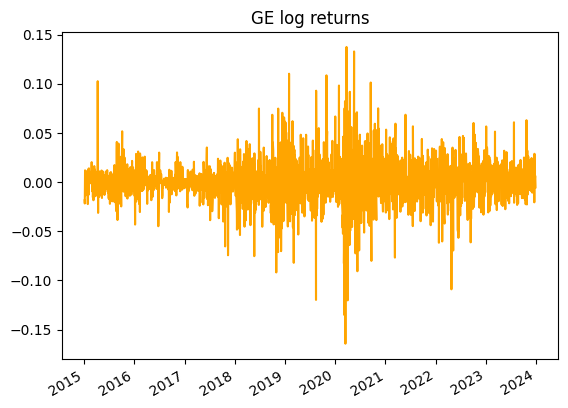

In [27]:
returns_ge.plot(title="GE log returns", color="orange")

<br><br><br><br>
<h3>Distribution of returns</h3>

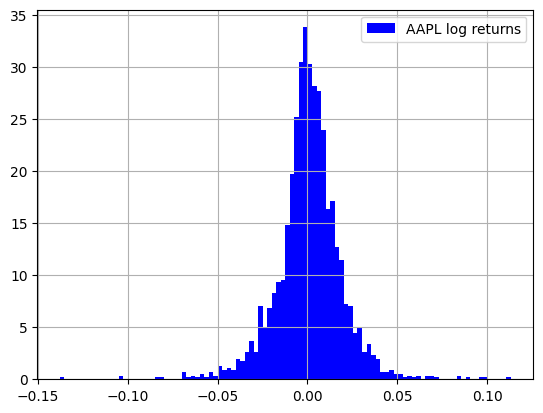

In [39]:
returns_aapl.hist(bins=100, density=True, color='b', label='AAPL log returns')
plt.legend()

<br><br><br><br>
<p>Fitting distributions to APPL log-returns</p>

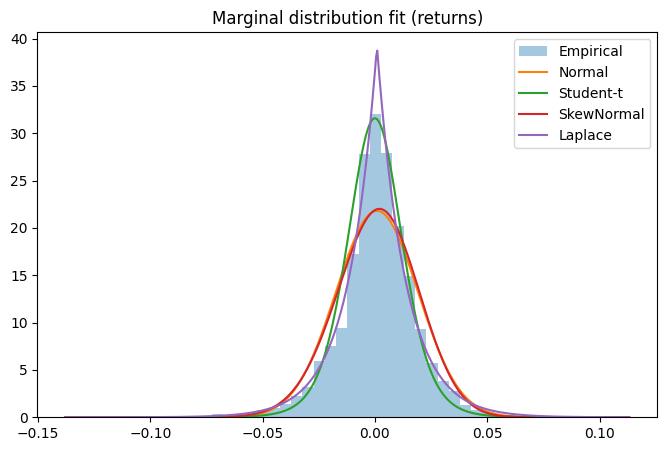

,Distribution,KS statistic,p-value
3,Laplace,0.026780,7.646080e-02
1,Student-t,0.043607,3.543307e-04
2,SkewNormal,0.073550,4.312240e-11
0,Normal,0.078794,1.145763e-12


In [43]:

# Choose returns (assumed already computed)
x = returns_aapl.values
x = x[np.isfinite(x)]

# Candidate distributions
distributions = {
    "Normal": stats.norm,
    "Student-t": stats.t,
    "SkewNormal": stats.skewnorm,
    "Laplace": stats.laplace
}

results = []

# Grid-search df for Student-t (optional, otherwise MLE handles it)
t_df_grid = [3, 5, 8, 12, 20]

# Histogram base
plt.figure(figsize=(8, 5))
plt.hist(x, bins=50, density=True, alpha=0.4, label="Empirical")

xx = np.linspace(x.min(), x.max(), 500)

for name, dist in distributions.items():
    if name == "Student-t":
        best = None

        for df in t_df_grid:
            params = (df,) + dist.fit(x, floc=0)[1:]
            ks_stat, pval = stats.kstest(x, dist.cdf, args=params)

            if best is None or ks_stat < best["ks"]:
                best = {"params": params, "ks": ks_stat, "pval": pval}

        params = best["params"]
        ks_stat = best["ks"]
        pval = best["pval"]

    else:
        params = dist.fit(x)
        ks_stat, pval = stats.kstest(x, dist.cdf, args=params)

    results.append({
        "Distribution": name,
        "KS statistic": ks_stat,
        "p-value": pval
    })

    pdf = dist.pdf(xx, *params)
    plt.plot(xx, pdf, label=f"{name}")

plt.title("Marginal distribution fit (returns)")
plt.legend()
plt.show()

# Display results
results_df = pd.DataFrame(results).sort_values("KS statistic")
results_df

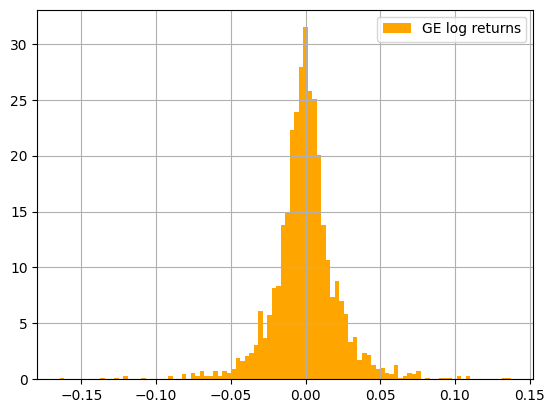

In [36]:
returns_ge.hist(bins=100, density=True, color='orange', label='GE log returns')
plt.legend()

<br><br><br><br>
<p>Fitting distributions to GE log-returns</p>

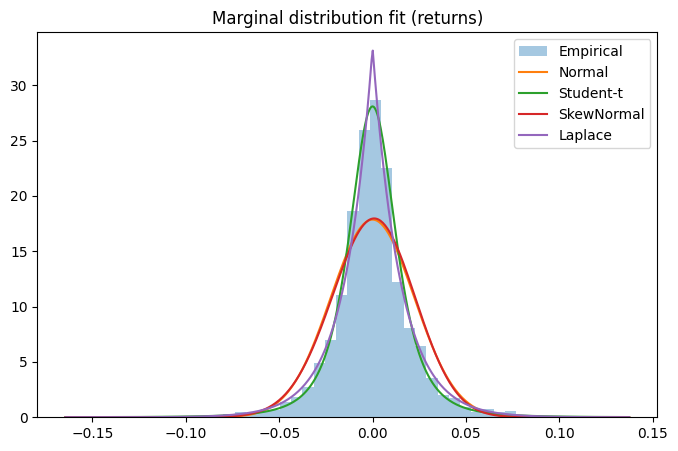

,Distribution,KS statistic,p-value
3,Laplace,0.020225,3.086964e-01
1,Student-t,0.021033,2.656730e-01
0,Normal,0.091438,6.473858e-17
2,SkewNormal,0.093171,1.511643e-17


In [44]:

# Choose returns (assumed already computed)
x = returns_ge.values
x = x[np.isfinite(x)]

# Candidate distributions
distributions = {
    "Normal": stats.norm,
    "Student-t": stats.t,
    "SkewNormal": stats.skewnorm,
    "Laplace": stats.laplace
}

results = []

# Grid-search df for Student-t (optional, otherwise MLE handles it)
t_df_grid = [3, 5, 8, 12, 20]

# Histogram base
plt.figure(figsize=(8, 5))
plt.hist(x, bins=50, density=True, alpha=0.4, label="Empirical")

xx = np.linspace(x.min(), x.max(), 500)

for name, dist in distributions.items():
    if name == "Student-t":
        best = None

        for df in t_df_grid:
            params = (df,) + dist.fit(x, floc=0)[1:]
            ks_stat, pval = stats.kstest(x, dist.cdf, args=params)

            if best is None or ks_stat < best["ks"]:
                best = {"params": params, "ks": ks_stat, "pval": pval}

        params = best["params"]
        ks_stat = best["ks"]
        pval = best["pval"]

    else:
        params = dist.fit(x)
        ks_stat, pval = stats.kstest(x, dist.cdf, args=params)

    results.append({
        "Distribution": name,
        "KS statistic": ks_stat,
        "p-value": pval
    })

    pdf = dist.pdf(xx, *params)
    plt.plot(xx, pdf, label=f"{name}")

plt.title("Marginal distribution fit (returns)")
plt.legend()
plt.show()

# Display results
results_df = pd.DataFrame(results).sort_values("KS statistic")
results_df

<br><br><br><br>
<h3>Correlation of returns</h3>

In [42]:
R = pd.concat([returns_aapl, returns_ge], axis=1).dropna()
R.columns = ["AAPL", "GE"]

R.corr()

,AAPL,GE
AAPL,1.000000,0.349112
GE,0.349112,1.000000


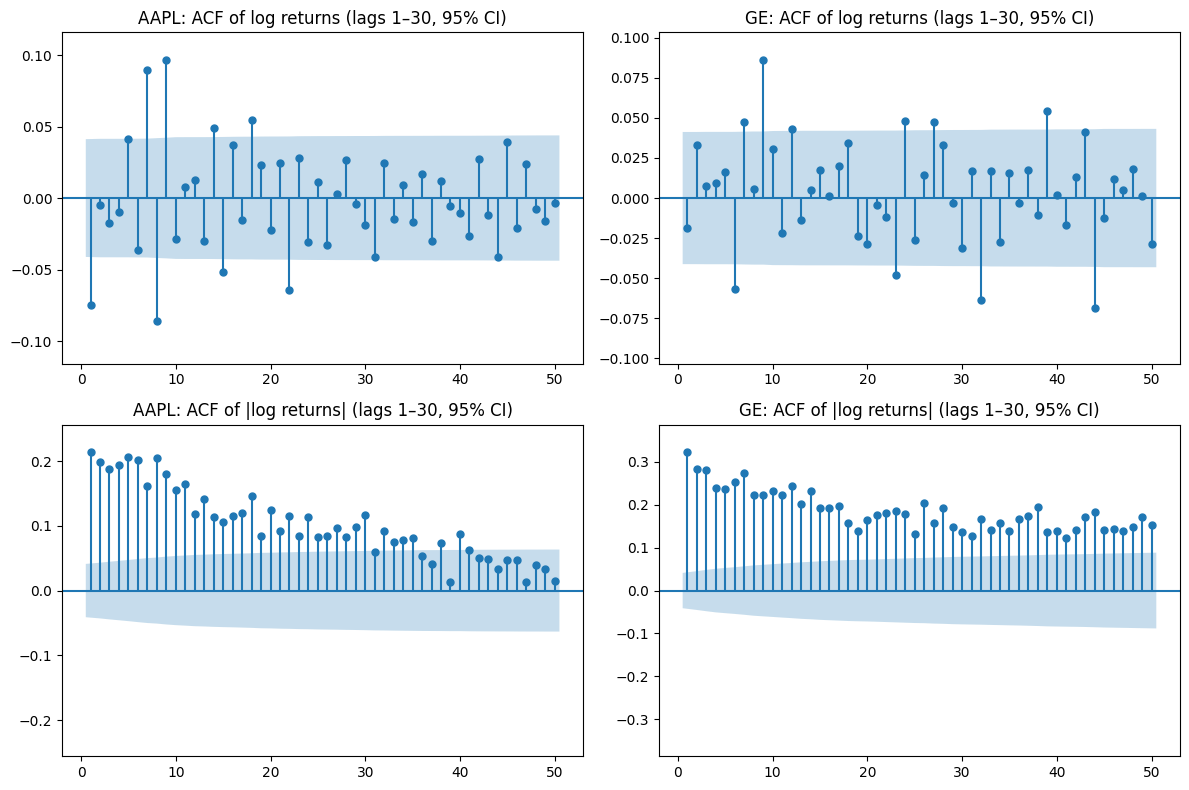

In [52]:
lags = 50
conf_level = 0.95

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

def plot_acf_scaled(series, ax, title):
    plot_acf(
        series,
        lags=lags,
        ax=ax,
        zero=False,
        alpha=1 - conf_level
    )

    # Get current y-data limits from plotted lines
    lines = ax.lines
    y_vals = np.concatenate([line.get_ydata() for line in lines if len(line.get_ydata()) > 0])

    # Add padding
    ymax = np.max(np.abs(y_vals))
    ax.set_ylim(-1.2 * ymax, 1.2 * ymax)

    ax.set_title(title)


# --- AAPL ---
plot_acf_scaled(
    returns_aapl,
    axes[0, 0],
    "AAPL: ACF of log returns (lags 1–30, 95% CI)"
)

plot_acf_scaled(
    abs(returns_aapl),
    axes[1, 0],
    "AAPL: ACF of |log returns| (lags 1–30, 95% CI)"
)

# --- GE ---
plot_acf_scaled(
    returns_ge,
    axes[0, 1],
    "GE: ACF of log returns (lags 1–30, 95% CI)"
)

plot_acf_scaled(
    abs(returns_ge),
    axes[1, 1],
    "GE: ACF of |log returns| (lags 1–30, 95% CI)"
)

plt.tight_layout()
plt.show()

<br><br><br><br>
<h2>text</h2>